In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy import sparse
from scipy import optimize
from functools import reduce
from collections import defaultdict
from tqdm.notebook import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
def get_num_baselines(Nside):
    # For square of N telescopes, should be 2N-2*sqrt(N) + 1
    # Fix to a corner and there are N-1 options for unique baselines. 
    # Flip over to other side (over x or y axis) and get another N-1 options
    # Duplicated are the pure x-axis and pure y-axis so -2*(sqrt(N)-1)
    # Final +1 is from 0 baseline
    
    N_bases = 2*Nside**2 - 2*Nside
    return int(N_bases)

rand_phases = lambda x: np.random.uniform(0, 2*np.pi, x)
zero_weight = lambda x, d: x/d if d else 0

def make_gains(Nside):
    # Create complex gains with either (amplitude, phase) or (real, imaginary)
    Nant = Nside**2
    gain_amp = np.random.normal(1, .05, Nant)
    gain_phase = rand_phases(Nant)
    tgain = gain_amp*np.exp(1j*gain_phase)    
    return tgain

def make_data(Nside, gains, noise=0.1):
    Nant = Nside**2
    Nbase = get_num_baselines(Nside)
    vis_true = np.random.normal(0,1,size=(Nbase,2)).view(np.complex128).flatten() ## size of unique baselines
    ant_i, ant_j, visndx, data = [], [], [], []
    ndx=0
    ndx2base={}
    base2ndx={}
    for i in range(Nant):
        xi,yi=np.unravel_index(i,(Nside,Nside))
        for j in range (i+1,Nant):
            xj,yj=np.unravel_index(j,(Nside,Nside))
            assert (xj>=xi)
            baseline = (xj-xi,yj-yi)
            if baseline in base2ndx:
                cndx = base2ndx[baseline]
            else:
                cndx = ndx
                base2ndx[baseline]=ndx
                ndx2base[ndx]=baseline
                ndx+=1
            ant_i.append(i)
            ant_j.append(j)
            visndx.append(cndx)
            data.append(vis_true[cndx]*gains[i]*np.conj(gains[j]))
            
    assert(ndx==Nbase)
    ant_i = np.array(ant_i)
    ant_j = np.array(ant_j)
    visndx = np.array(visndx)
    data = np.array(data)
    noise = np.random.normal(0,noise,size=(len(data),2)).view(np.complex128).flatten() ## size of unique baselines
    data += noise
    return vis_true, data, ant_i, ant_j, visndx

In [4]:
def make_pred(gains, vis, ant_i, ant_j, visndx):
    gains_i = gains[ant_i]
    cgains_j = np.conj(gains[ant_j])
    pred = gains_i*cgains_j*vis[visndx]
    return pred

In [5]:
def chi2 (data, gains, vis, ant_i, ant_j, visndx, noise=0.1):
    pred = make_pred(gains, vis, ant_i, ant_j, visndx)
    chi2 = np.abs((data - pred)**2).sum()/(noise**2)
    dof = len(data)*2
    return chi2, dof

In [6]:
def flat_to_matrix(Nside, flattened, a_i, a_j):
    Nant = Nside**2
    temp_mat = np.zeros((Nant, Nant), dtype=np.complex128)
    temp_mat[a_i, a_j] = flattened
    temp_mat[a_j, a_i] = np.conj(flattened)
    return temp_mat

In [407]:
Nside = 8
Nant = Nside * Nside
Nbase = get_num_baselines(Nside)
gains_true = make_gains(Nside)
vis_true, data, ant_i, ant_j, visndx = make_data(Nside, gains_true)
data_len = len(data)

In [408]:
no_noise = make_pred(gains_true, vis_true, ant_i, ant_j, visndx)

In [409]:
phased_gains = gains_true*np.exp(1j*rand_phases(Nant)/5)

In [410]:
chi2(data, gains_true, vis_true, ant_i, ant_j, visndx)

(4142.707223979229, 4032)

In [443]:
def omnical(iter_max, data, g0, v0, ant_i, ant_j, visndx, noise=0.1, delta=0.4, epsilon=1e-5):
    garr = g0.copy()
    varr = v0.copy()
    Nant = len(g0)
    Nbase = len(v0)
    chiscores = []
    for n in range(iter_max):
        start_pred = make_pred(garr, varr, ant_i, ant_j, visndx)
#         weights = start_pred**2/(noise**2)
        weights = np.ones_like(start_pred)/(noise**2)
        
        gprime = np.zeros(Nant, dtype=np.complex128)
        for i in range(Nant):
            numer = np.complex(0, 0)
            denom = np.complex(0, 0)
            iant = np.where(ant_i == i)[0]
            jant = np.where(ant_j == i)[0]
            numer += ((weights[iant] * data[iant])/(start_pred[iant])).sum()
            denom += weights[iant].sum()
            numer += ((weights[jant] * np.conj(data[jant]))/(np.conj(start_pred[jant]))).sum()
            denom += weights[jant].sum()
            gprime[i] = garr[i]*zero_weight(numer,denom)
            
        garr = (1 - delta)*garr + delta*gprime
        
        vprime = np.zeros(Nbase, dtype=np.complex128)
        for i in range(Nbase):
            indxs = np.where(visndx==i)
            numer = ((weights[indxs]*data[indxs])/start_pred[indxs]).sum()
            denom = (weights[indxs]).sum()
            vprime[i] = varr[i]*numer/denom
        varr = (1-delta)*varr + delta*vprime
        
        gscale = 1/np.mean(np.abs(garr))
        vscale = (1/gscale)**2
        garr = garr*gscale
        varr = varr*vscale
        
        chi, _ = chi2(data, garr, varr, ant_i, ant_j, visndx)
        chiscores.append(chi)
        if n > 20:
            if np.abs(chiscores[-2] - chiscores[-1]) < epsilon:
                break
    return garr, varr, chiscores, n

In [438]:
def chimincal(iter_max, data, g0, v0, ant_i, ant_j, visndx, noise=0.1, delta=0.4, epsilon=1e-5):
    chiscores = []
    garr = g0.copy()
    varr = v0.copy()
    N = 1
    Nant = len(g0)
    Nbase = len(v0)
    
    for n in range(iter_max):
        gprime = np.zeros(Nant, dtype=np.complex128)
        for i in range(Nant):
            numer = np.complex(0, 0)
            denom = np.complex(0, 0)
            iant = np.where(ant_i == i)[0]
            jant = np.where(ant_j == i)[0]
            numer += (data[iant] * garr[ant_j[iant]]*np.conj(varr[visndx[iant]])).sum()
            denom += (np.abs(garr[ant_j[iant]]*varr[visndx[iant]])**2).sum()
            numer += (np.conj(data[jant]) * garr[ant_i[jant]]*varr[visndx[jant]]).sum()
            denom += (np.abs(garr[ant_i[jant]]*varr[visndx[jant]])**2).sum()
            gprime[i] += zero_weight(numer, denom)

        garr = (1 - delta)*garr + delta*gprime
        
        vprime = np.zeros(Nbase, dtype=np.complex128)
        for i in range(Nbase):
#             vdata = data/(garr[ant_i]*np.conj(garr[ant_j]))
#             vprime[i] = np.mean(vdata[visndx==i])
            
#             numer = data[indxs].sum()
#             denom = (garr[ant_i[indxs]]*np.conj(garr[ant_j[indxs]])).sum()
#             vprime[i] += zero_weight(numer, denom)

            indxs = np.where(visndx==i)
            numer = (data[indxs]*np.conj(garr[ant_i[indxs]])*garr[ant_j[indxs]]).sum()
            denom = (np.abs(garr[ant_i[indxs]]*np.conj(garr[ant_j[indxs]]))**2).sum()
            vprime[i] = zero_weight(numer, denom)

        varr = (1-delta)*varr + delta*vprime
#         varr = vprime


    
        gscale = N/np.mean(np.abs(garr))
        garr *= gscale
        varr *= (1/gscale)**2
        
        chi, _ = chi2(data, garr, varr, ant_i, ant_j, visndx)
        chiscores.append(chi)
        if n > 20:
            if np.abs(chiscores[-2] - chiscores[-1]) < epsilon:
                break
    return garr, varr, chiscores, n

In [444]:
g, v, c, n = omnical(50, data, phased_gains, vis_true, ant_i, ant_j, visndx, delta=.4)
# g, v, c, n = chimincal(20, data, phased_gains, vis_true, ant_i, ant_j, visndx, delta=.4)

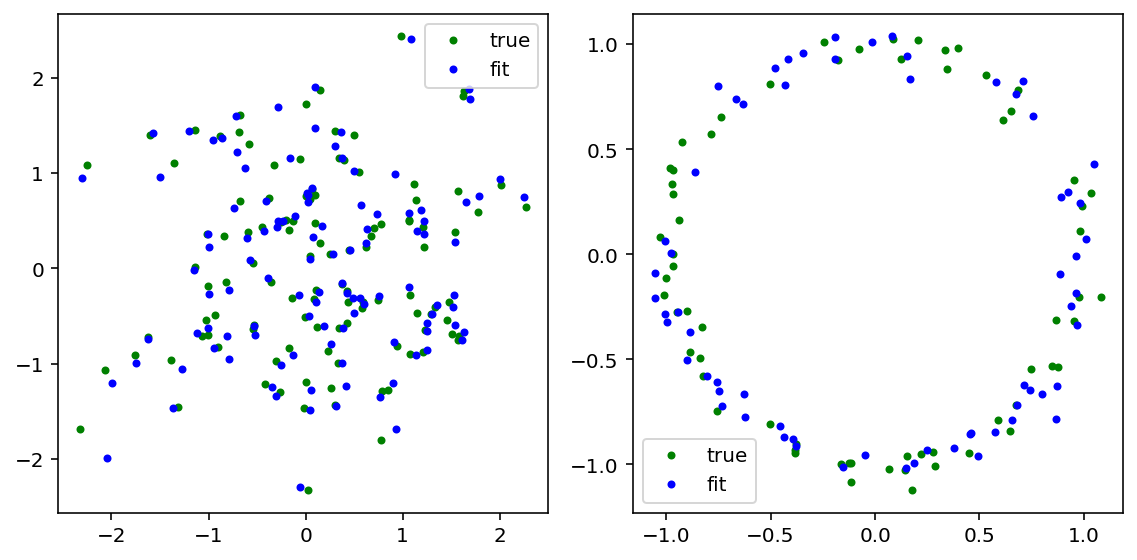

In [445]:
fig, ax = plt.subplots(ncols=2, figsize=(8,4))
ax[0].plot(vis_true.real, vis_true.imag, 'g.', label='true')
ax[0].plot(v.real, v.imag, 'b.', label='fit')
ax[0].legend()

ax[1].plot(gains_true.real, gains_true.imag, 'g.', label='true')
ax[1].plot(g.real, g.imag, 'b.', label='fit')
ax[1].legend()

plt.tight_layout()


In [465]:
def compare(Nside, true_gain, reps, noise_a=.1, **kwargs):
    tgain = true_gain.copy()
    Nant = len(tgain)
    Nbase = get_num_baselines(Nside)
    # Set up variables to fill in during the runs

    omni_gains = np.zeros((reps, Nant), dtype=np.complex128)
    chi_gains = np.zeros_like(omni_gains)
    omni_chi_gains = np.zeros_like(omni_gains)
    omni_avg_gain = np.zeros_like(omni_gains)
    chi_avg_gain = np.zeros_like(omni_avg_gain)
    
    omni_valp = np.zeros((reps, Nbase), dtype=np.complex128)
    chi_valp = np.zeros_like(omni_valp)
    omni_chi_valp = np.zeros_like(omni_valp)
    omni_avg_valp = np.zeros_like(omni_valp)
    chi_avg_valp = np.zeros_like(omni_valp)
    omni_chis = []
    chi_chis = []
    guess_chis = []
    fin_n = np.zeros((reps, 2))
    
    n_sigma = noise_a**2

    for n in tqdm(range(reps)):
        # Generate observed data
        vis_true, data, ant_i, ant_j, visndx = make_data(Nside, tgain, noise=noise_a)
        Nbase = len(vis_true)
        # Set up guesses
        vguess = np.zeros(Nbase, dtype=np.complex128)
        for i in range(Nbase):
            vguess[i] = np.mean(data[visndx==i])
            
        gguess = tgain*np.exp(1j*np.random.uniform(-np.pi/8, np.pi/8, Nant))
        chiguess, _ = chi2(data, gguess, vguess, ant_i, ant_j, visndx)
        guess_chis.append(chiguess)

        # Solve with different methods
        gomni, vomni, omnichi, omnin = omnical(data=data, g0=gguess, v0=vguess, ant_i=ant_i, ant_j=ant_j, visndx=visndx, **kwargs)
        gchi, vchi, chichi, chin = chimincal(data=data, g0=gguess, v0=vguess, ant_i=ant_i, ant_j=ant_j, visndx=visndx, **kwargs)
        # Put results in the right place
        omni_avg_gain[n] = gomni
        omni_avg_valp[n] = vomni
        
        chi_avg_gain[n] = gchi
        chi_avg_valp[n] = vchi
        
        omni_gains[n] = gomni - tgain
        chi_gains[n] = gchi - tgain
        omni_chi_gains[n] = gomni - gchi
        
        omni_valp[n] = vomni - vis_true
        chi_valp[n] = vchi - vis_true
        omni_chi_valp[n] = vomni - vchi
        
        omni_chis.append(omnichi)
        chi_chis.append(chichi)
        
        fin_n[n] = (omnin, chin)
    # Using median to stop one bad apple from blowing up averages
    fomni_avg_gain = np.median(omni_avg_gain, axis=0)
    fomni_avg_valp = np.median(omni_avg_valp, axis=0)
    fchi_avg_gain = np.median(chi_avg_gain, axis=0)
    fchi_avg_valp = np.median(chi_avg_valp, axis=0)
    
    return omni_gains, chi_gains, omni_chi_gains, omni_valp, chi_valp, omni_chi_valp, omni_chis, chi_chis, guess_chis, fin_n, fomni_avg_gain, fomni_avg_valp, fchi_avg_gain, fchi_avg_valp

In [466]:
# Optional arguments for chimin and omnical
compare_dict = {"iter_max": 400, "delta": .2, "epsilon": 1e-5}

In [500]:
# Get trials data
trials = compare(8, gains_true, 100, **compare_dict)

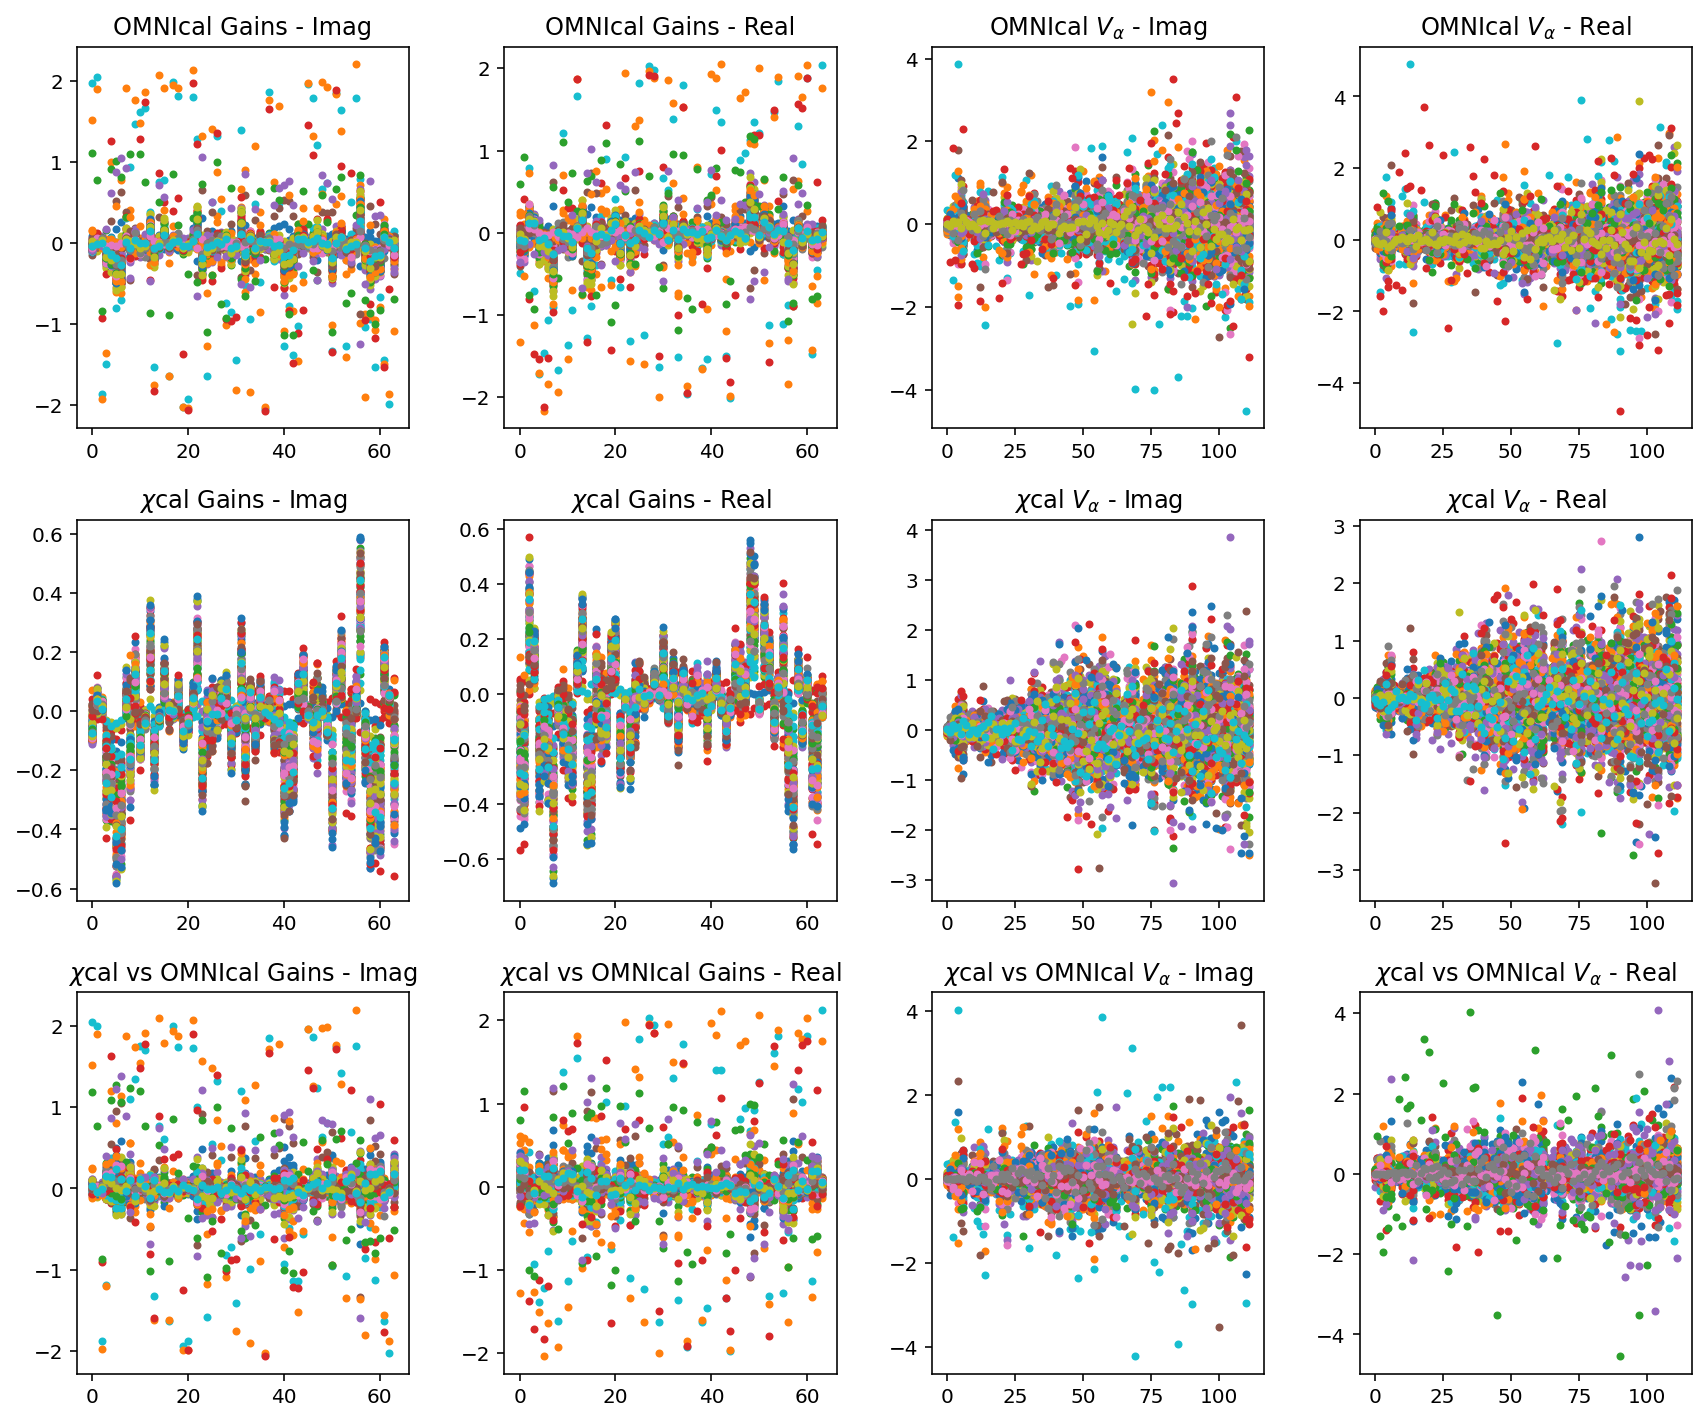

In [501]:
# Lots of plotting
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12,10))
# Simple filter to remove plots that blew up/clearly bad
iflambda = lambda x : np.max(np.abs(x)) < 5 and True

for i in trials[0].imag:
    if iflambda(i):
        axes[0,0].plot(i, '.')
# axes[0,0].plot((trials[-4] - tgain).imag)
axes[0,0].set_title("OMNIcal Gains - Imag")

for i in trials[0].real:
    if iflambda(i):
        axes[0,1].plot(i, '.')
# axes[0,1].plot((trials[-4] - tgain).real)
axes[0,1].set_title("OMNIcal Gains - Real")

for i in trials[3].imag:
    if iflambda(i):
        axes[0,2].plot(i, '.')
# axes[0,2].plot((trials[-3] - valpha).imag)
axes[0,2].set_title(r"OMNIcal $V_\alpha$ - Imag")

for i in trials[3].real:
    if iflambda(i):
        axes[0,3].plot(i, '.')
# axes[0,3].plot((trials[-3] - valpha).real)
axes[0,3].set_title(r"OMNIcal $V_\alpha$ - Real")

for i in trials[1].imag:
    if iflambda(i):
        axes[1,0].plot(i, '.')
# axes[1,0].plot((trials[-2] - tgain).imag)
axes[1,0].set_title(r"$\chi$cal Gains - Imag")

for i in trials[1].real:
    if iflambda(i):
        axes[1,1].plot(i, '.')
# axes[1,1].plot((trials[-2] - tgain).real)
axes[1,1].set_title(r"$\chi$cal Gains - Real")

for i in trials[4].imag:
    if iflambda(i):
        axes[1,2].plot(i, '.')
# axes[1,2].plot((trials[-1] - valpha).imag)
axes[1,2].set_title(r"$\chi$cal $V_\alpha$ - Imag")

for i in trials[4].real:
    if iflambda(i):
        axes[1,3].plot(i, '.')
# axes[1,3].plot((trials[-1] - valpha).real)
axes[1,3].set_title(r"$\chi$cal $V_\alpha$ - Real")

for i in trials[2].imag:
    if iflambda(i):
        axes[2,0].plot(i, '.')
axes[2,0].set_title(r"$\chi$cal vs OMNIcal Gains - Imag")

for i in trials[2].real:
    if iflambda(i):
        axes[2,1].plot(i, '.')
axes[2,1].set_title(r"$\chi$cal vs OMNIcal Gains - Real")

for i in trials[5].imag:
    if iflambda(i):
        axes[2,2].plot(i, '.')
axes[2,2].set_title(r"$\chi$cal vs OMNIcal $V_\alpha$ - Imag")

for i in trials[5].real:
    if iflambda(i):
        axes[2,3].plot(i, '.')
axes[2,3].set_title(r"$\chi$cal vs OMNIcal $V_\alpha$ - Real")



plt.tight_layout()

In [502]:
np.mean(trials[1].real, axis=0)

array([-2.02777849e-01, -2.36141189e-01,  2.68304200e-01,  1.48284284e-01,
       -2.15269254e-01, -1.43864225e-01, -1.94835845e-01, -3.88489207e-01,
       -3.98969378e-02, -1.07727562e-01, -1.61390190e-01, -1.98126948e-01,
        6.98119031e-02,  2.11730267e-01, -3.02172746e-01, -3.02157819e-01,
        3.09502752e-02, -6.40794158e-02, -8.12723866e-02,  1.11810071e-01,
        1.51458876e-01, -1.87917615e-01, -2.98425450e-02, -1.56906709e-01,
       -3.86604907e-02,  1.93551012e-02, -6.50931187e-03, -2.65358836e-03,
        3.96644360e-02, -3.62391738e-04,  1.11175197e-01, -5.17647745e-02,
        5.10648340e-02, -9.91353094e-02,  4.49607010e-02, -2.24717465e-02,
       -2.32148666e-02, -3.80830720e-03, -1.62098358e-02, -5.65908987e-02,
       -3.07221853e-02,  4.68727194e-02, -4.63680584e-02, -1.02732348e-01,
       -3.61560026e-02,  7.75747764e-02,  4.26597545e-02,  1.26369006e-02,
        3.10072026e-01,  2.71883594e-01, -4.50887270e-02,  1.99967694e-01,
        1.19155956e-01, -

In [503]:
np.var(trials[1].real, axis=0)

array([0.01804733, 0.01573447, 0.01489615, 0.00275099, 0.00842872,
       0.00498678, 0.00762043, 0.01885814, 0.00129685, 0.00525411,
       0.00721541, 0.00702101, 0.0012724 , 0.00553185, 0.01278037,
       0.012232  , 0.00729573, 0.00598488, 0.00332114, 0.00288008,
       0.00352014, 0.00521563, 0.00013681, 0.0051997 , 0.00426089,
       0.00145962, 0.00076042, 0.0001065 , 0.00046272, 0.00010124,
       0.00362601, 0.00091713, 0.00110735, 0.00361217, 0.00082913,
       0.00022981, 0.00123177, 0.00173109, 0.00052061, 0.00447032,
       0.00023545, 0.00069834, 0.00041842, 0.00201571, 0.00044184,
       0.00382776, 0.00346915, 0.00111299, 0.0143603 , 0.01106952,
       0.00021223, 0.00618151, 0.00257125, 0.00219957, 0.00036347,
       0.01408528, 0.00897939, 0.01437103, 0.0014847 , 0.00154084,
       0.00066838, 0.01168923, 0.01569383, 0.00095984])

In [504]:
# Extract relevant chi2 information from the trials and calculate DoF
_, degree_of_freedoms = chi2(data, gains_true, vis_true, ant_i, ant_j, visndx)
degree_of_freedoms = np.int64(degree_of_freedoms)
omni_chis, chi_chis, start_chi = trials[6], trials[7], trials[8]
init_omni_chis = np.array([np.abs(chis[0]) for chis in omni_chis])
init_chi_chis = np.array([np.abs(chis[0]) for chis in chi_chis])
last_omni_chis = np.array([chis[-1] for chis in omni_chis])
last_chi_chis = np.array([chis[-1] for chis in chi_chis])

In [505]:
# chi2 doesn't throw away runs that blew up so manually remove any chi2 values that are major outliers
#last_omni_chis.pop(last_omni_chis.index(max(last_omni_chis)));
# last_chi_chis.pop(last_chi_chis.index(max(last_chi_chis)));

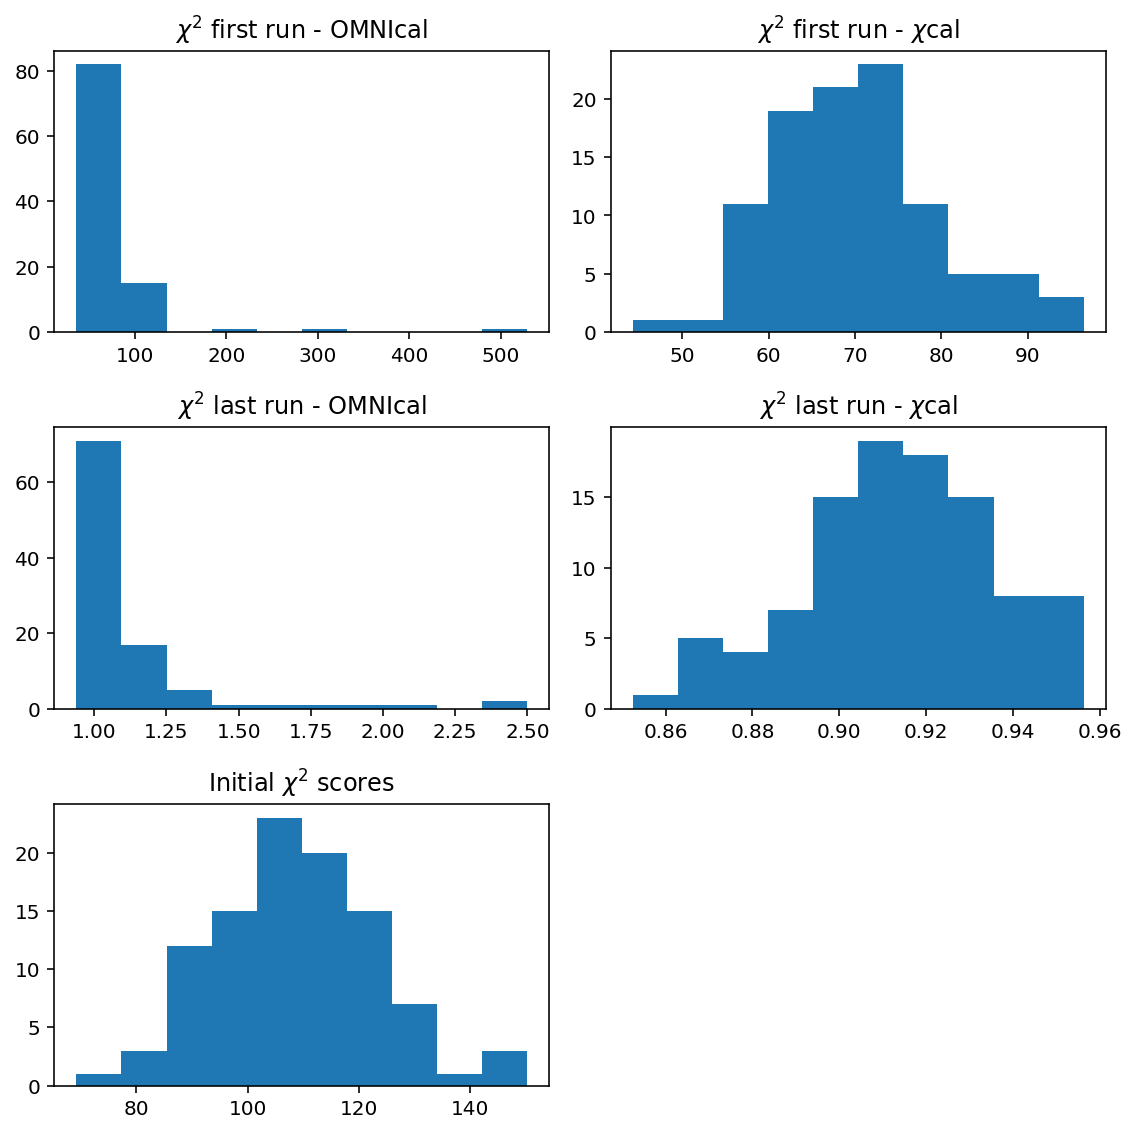

In [508]:
# chi2 plots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8,8))

axes[0,0].hist(init_omni_chis/degree_of_freedoms)
axes[0,0].set_title(r"$\chi^2$ first run - OMNIcal")

axes[0,1].hist(init_chi_chis/degree_of_freedoms)
axes[0,1].set_title(r"$\chi^2$ first run - $\chi$cal")

axes[1,0].hist(last_omni_chis/degree_of_freedoms)
# axes[1,0].set_xscale('log')
axes[1,0].set_title(r"$\chi^2$ last run - OMNIcal")

axes[1,1].hist(last_chi_chis/degree_of_freedoms)
axes[1,1].set_title(r"$\chi^2$ last run - $\chi$cal")

axes[2,0].hist(start_chi/degree_of_freedoms)
axes[2,0].set_title(r"Initial $\chi^2$ scores")
axes[2,1].remove()
 
plt.tight_layout()

In [509]:

degree_of_freedoms

4032

In [510]:
4096 - Nbase - Nant

3920